In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import itertools
import scanpy as sc

/home/dbeb/btech/bb1160039/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.3.1 pandas==1.0.3 scikit-learn==0.21.2 statsmodels==0.11.0 python-igraph==0.8.2


In [4]:
adata = sc.read_csv("/home/dbeb/btech/bb1160039/scratch/project/rmmulti/Human Brain/counts_non_genes_brain_human_3_rmmulti.csv").transpose()

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 17242 × 226923 

normalizing counts per cell
    finished (0:01:08)


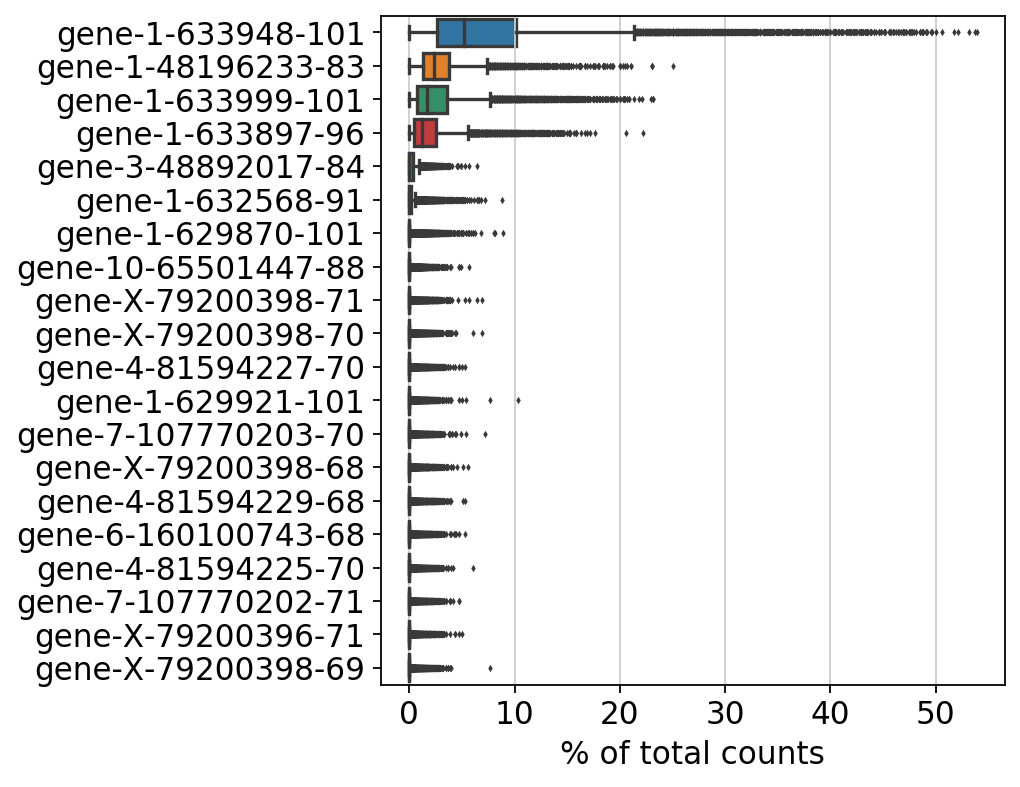

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6184 cells that have less than 100 genes expressed
filtered out 1605 genes that are detected in less than 3 cells


In [8]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

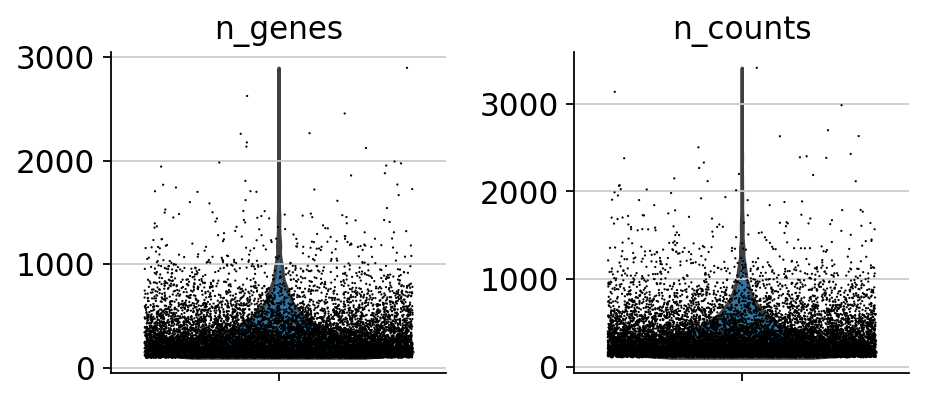

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

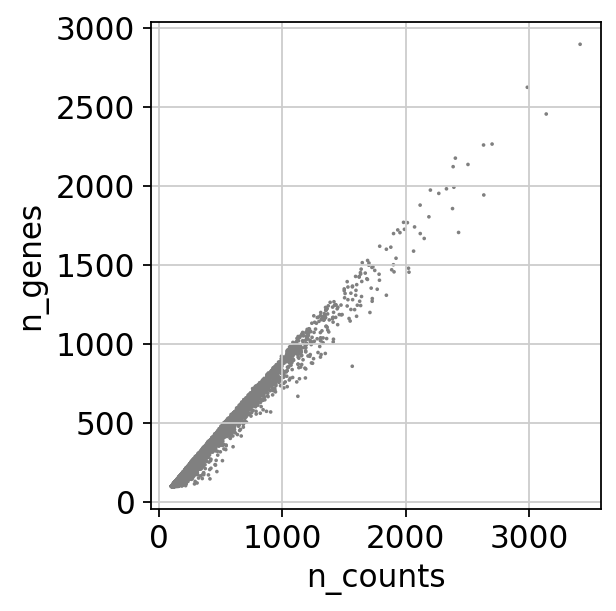

In [10]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata

AnnData object with n_obs × n_vars = 11058 × 225318 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

In [12]:
adata = adata[adata.obs.n_genes < np.percentile(adata.obs.n_genes,95), :]
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:13)


In [13]:
sc.pp.log1p(adata)
adata.raw = adata

/home/dbeb/btech/bb1160039/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


extracting highly variable genes
    finished (0:01:18)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


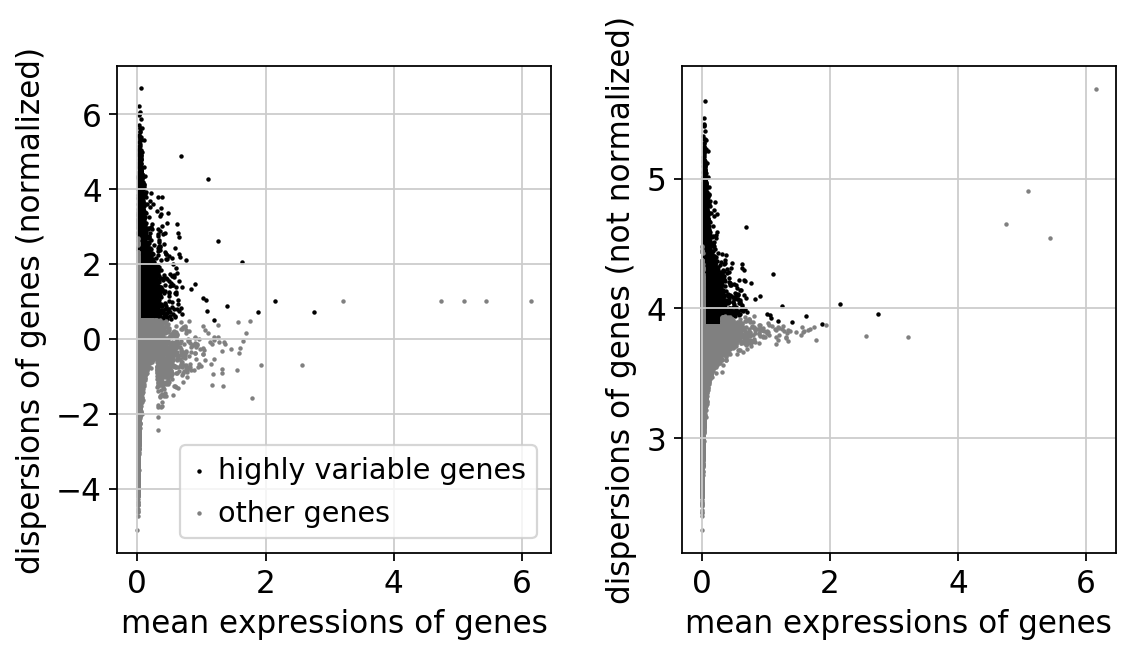

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

regressing out ['n_counts']
    finished (0:12:18)
    on highly variable genes
computing PCA with n_comps = 50
    finished (0:03:42)


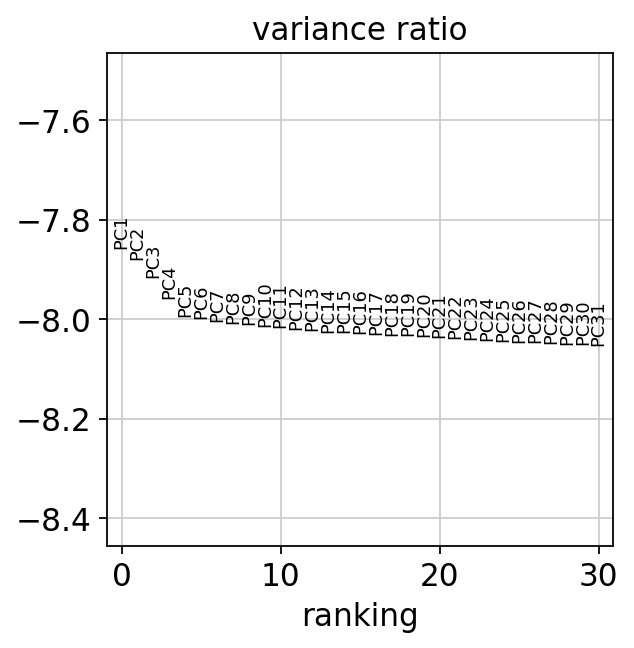

In [15]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [16]:
adata

AnnData object with n_obs × n_vars = 10504 × 64440 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


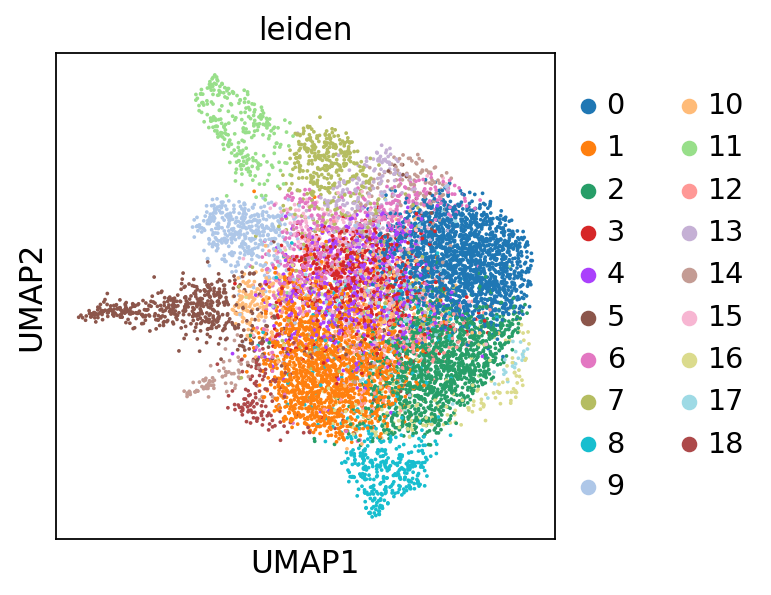

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:45)


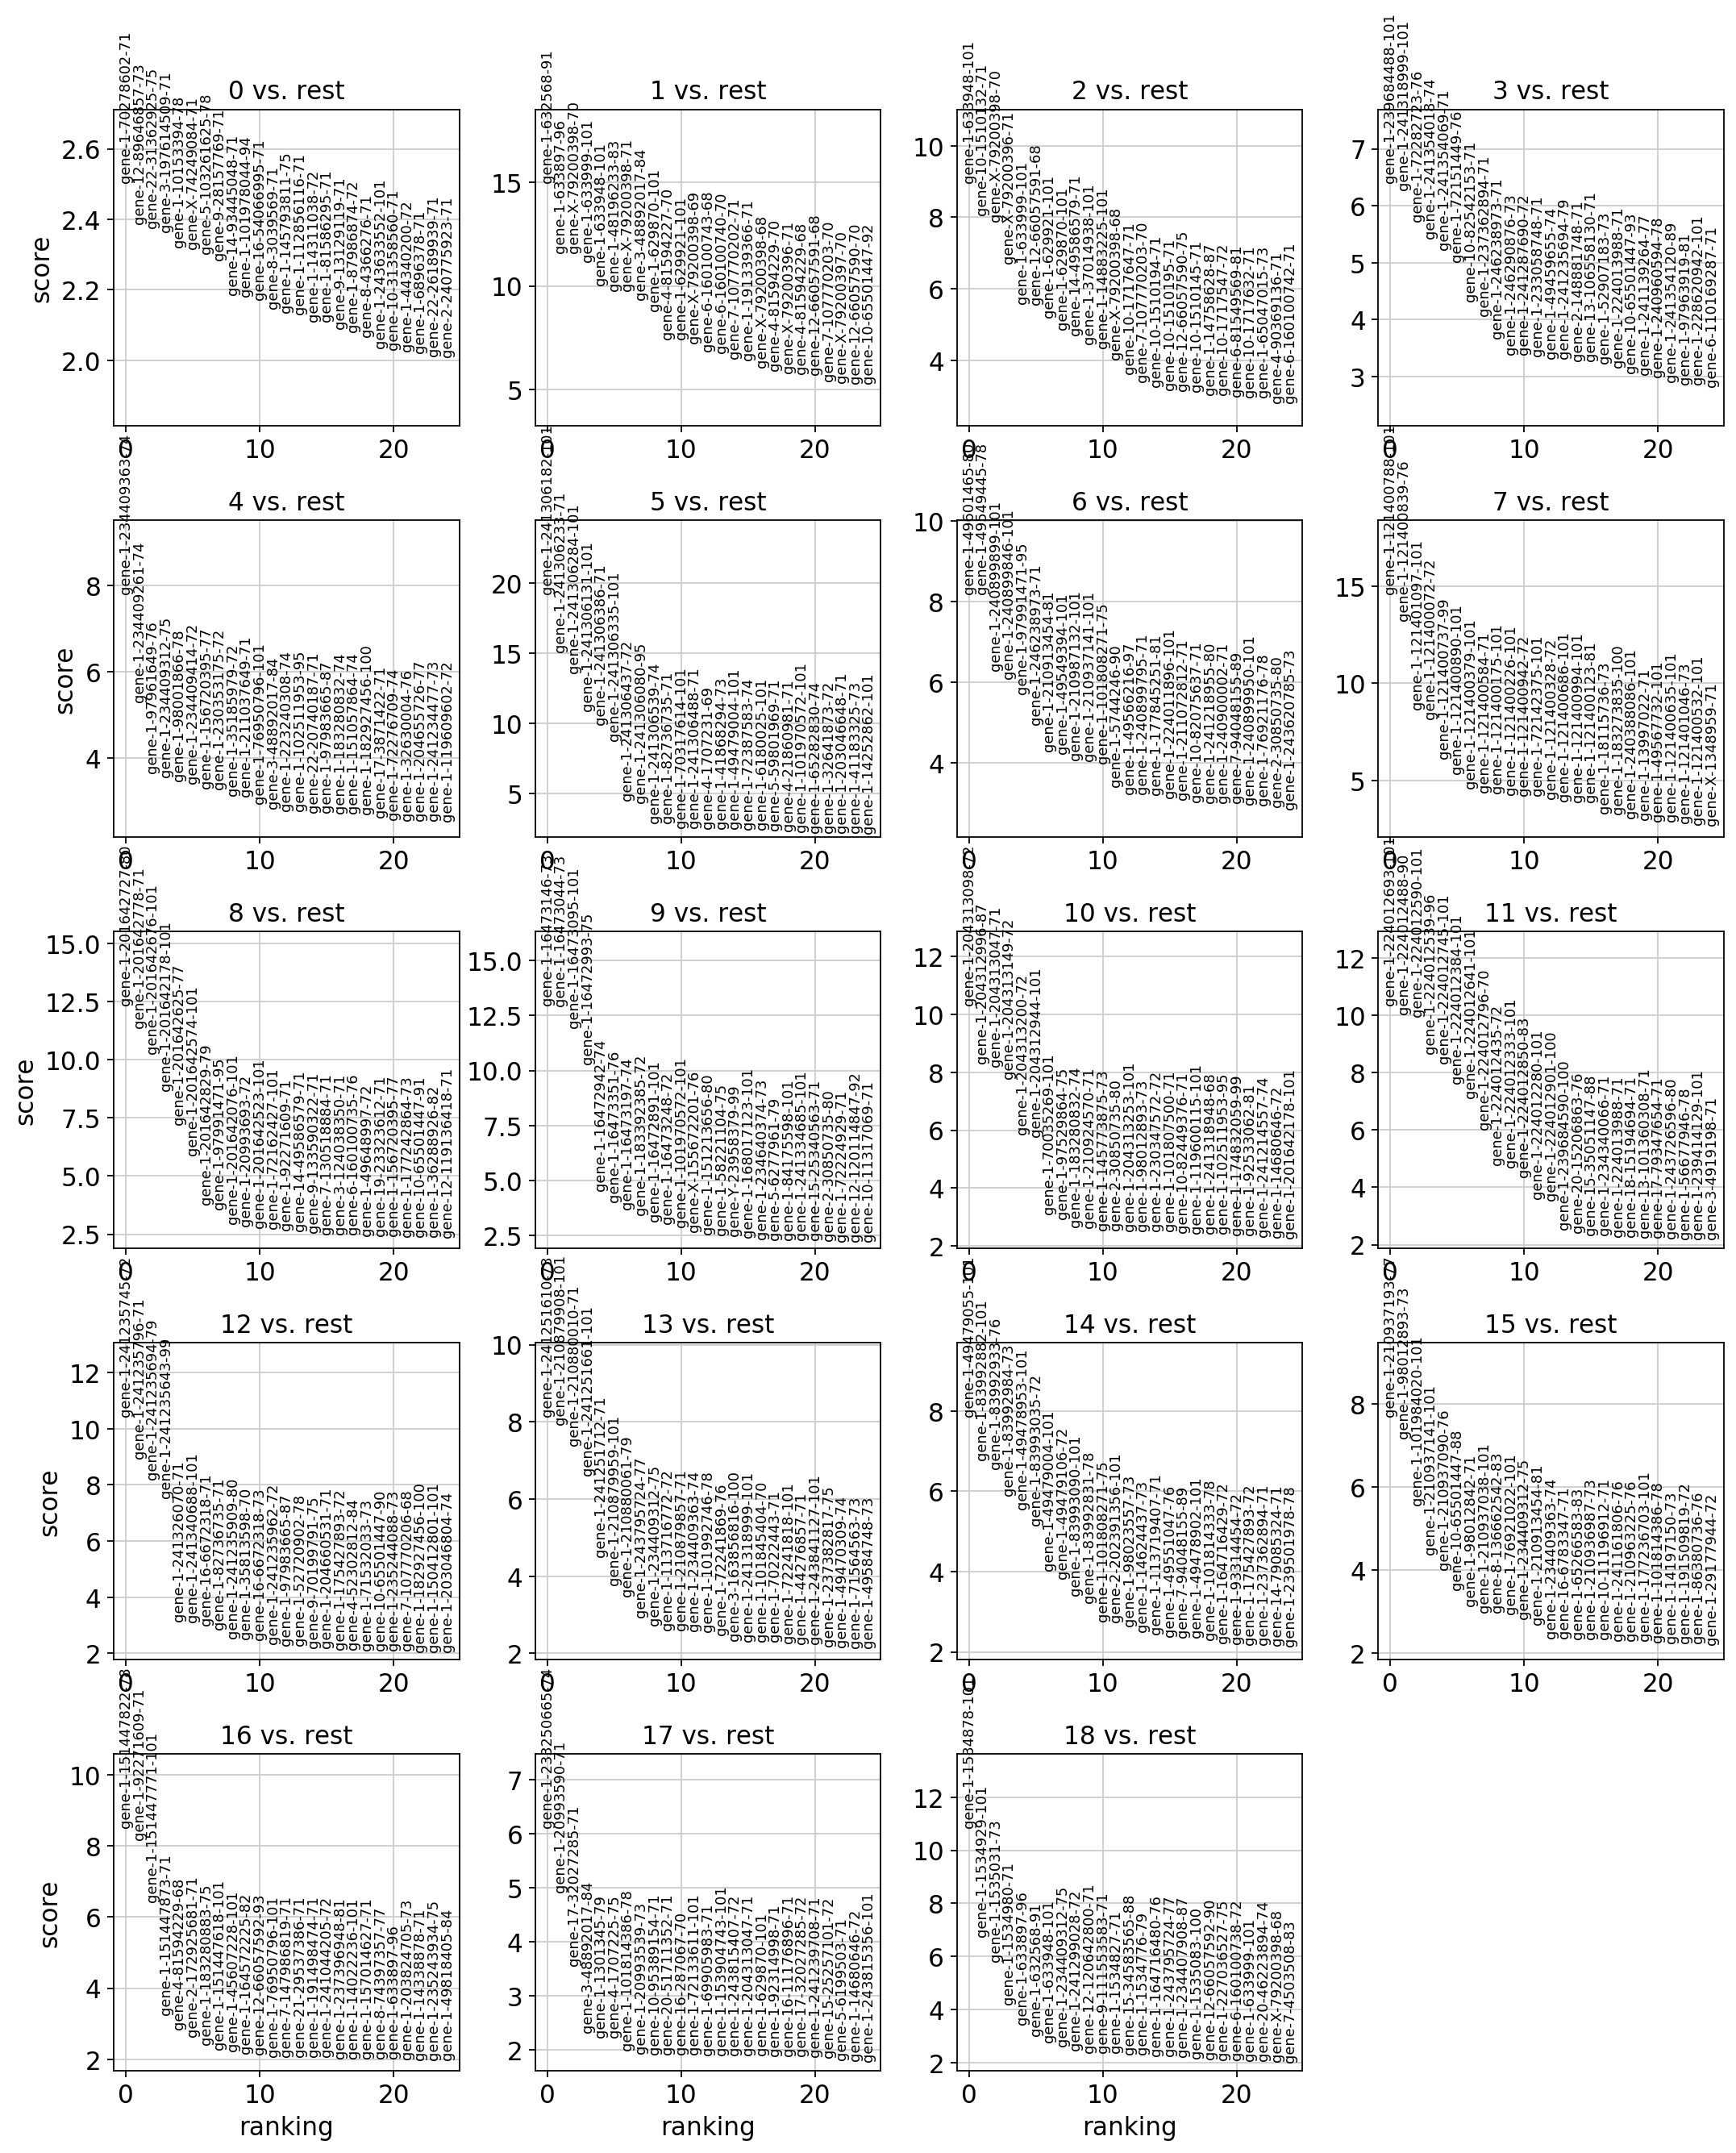

In [18]:
#Finding marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:07:03)


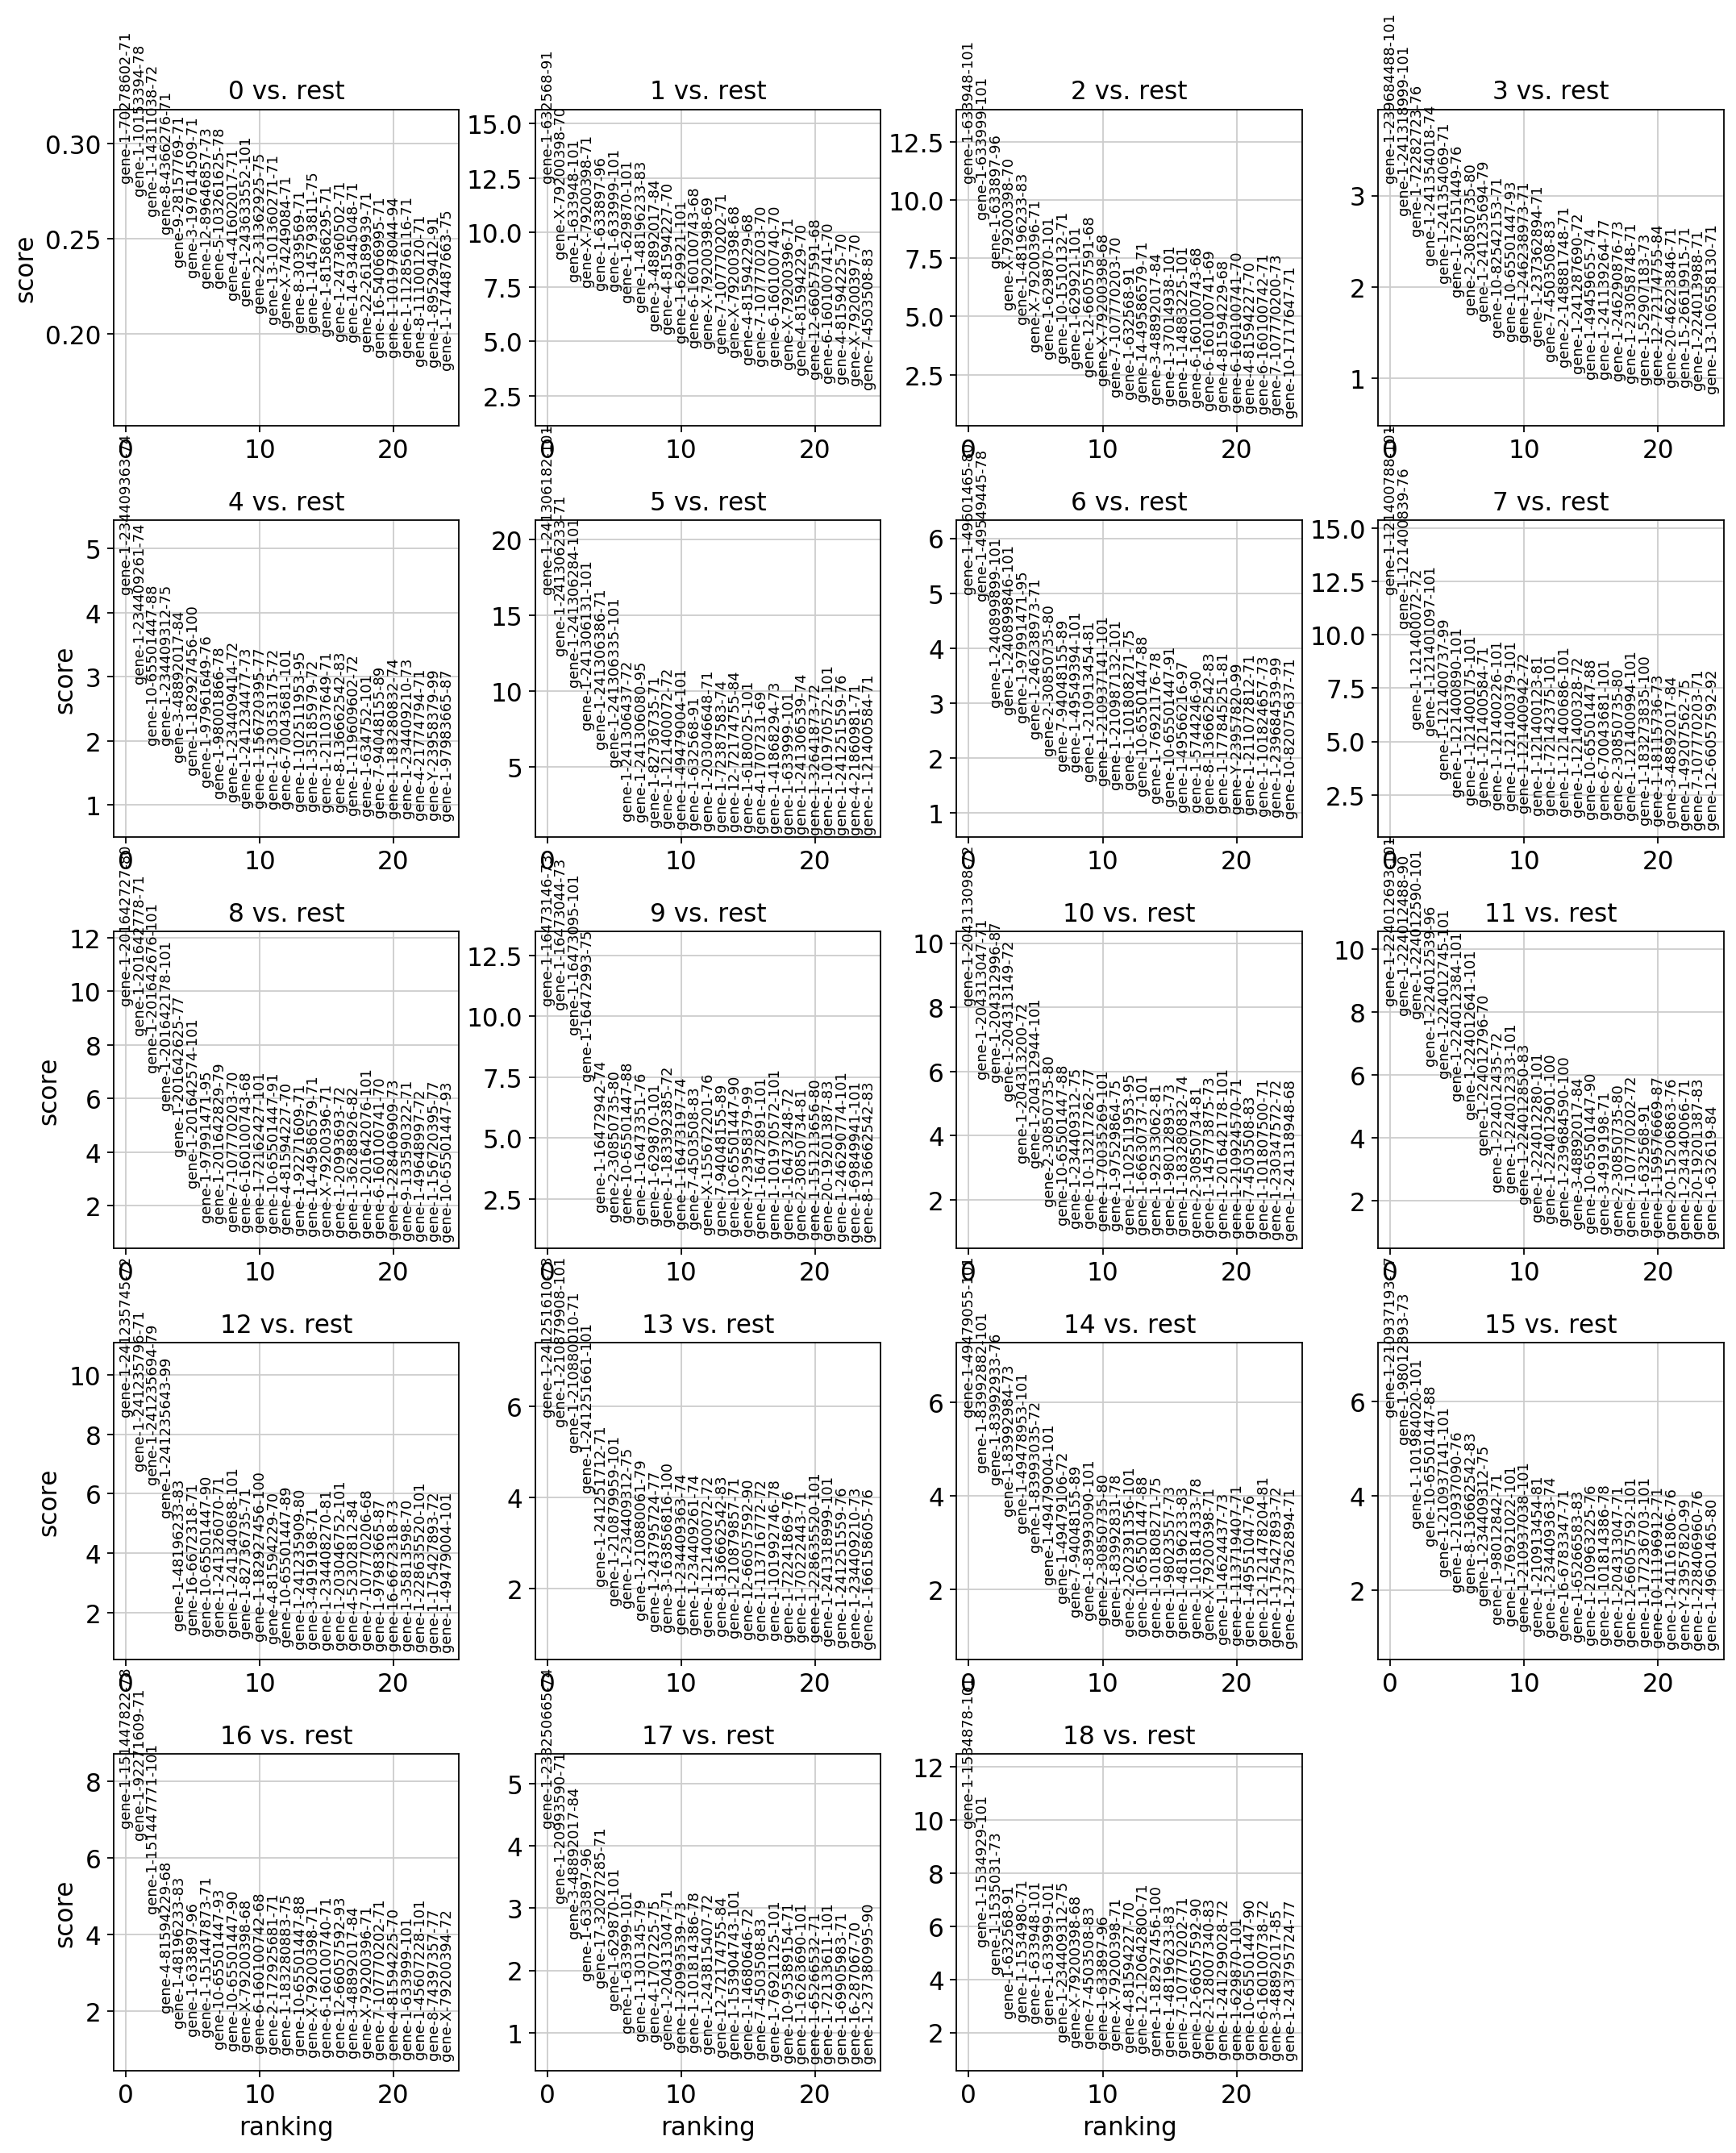

In [19]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
adata.var.index

Index(['gene-1-100003036-71', 'gene-1-100003196-99', 'gene-1-100003251-101',
       'gene-1-100011025-76', 'gene-1-100011079-75', 'gene-1-100014871-75',
       'gene-1-100020860-101', 'gene-1-100039324-71', 'gene-1-100041623-75',
       'gene-1-100041842-72',
       ...
       'gene-Y-23958086-99', 'gene-Y-23958161-99', 'gene-Y-23958562-99',
       'gene-Y-23958935-99', 'gene-Y-23959378-99', 'gene-Y-23981149-99',
       'gene-Y-23981872-99', 'gene-Y-25561799-100', 'gene-Y-3988191-101',
       'gene-Y-7155000-73'],
      dtype='object', length=64440)

In [24]:
lol=pd.DataFrame(adata.uns['rank_genes_groups']['names']).values.tolist()
flatlist=[item for sublist in lol for item in sublist]

In [25]:
flatlist

['gene-1-70278602-71',
 'gene-1-632568-91',
 'gene-1-633948-101',
 'gene-1-239684488-101',
 'gene-1-234409363-74',
 'gene-1-241306182-101',
 'gene-1-49601465-80',
 'gene-1-121400788-101',
 'gene-1-201642727-80',
 'gene-1-16473146-73',
 'gene-1-204313098-72',
 'gene-1-224012693-101',
 'gene-1-241235745-72',
 'gene-1-241251610-73',
 'gene-1-49479055-101',
 'gene-1-210937193-77',
 'gene-1-151447822-78',
 'gene-1-233250665-74',
 'gene-1-1534878-101',
 'gene-1-10153394-78',
 'gene-X-79200398-70',
 'gene-1-633999-101',
 'gene-1-241318999-101',
 'gene-1-234409261-74',
 'gene-1-241306233-71',
 'gene-1-49549445-78',
 'gene-1-121400839-76',
 'gene-1-201642778-71',
 'gene-1-16473044-73',
 'gene-1-204313047-71',
 'gene-1-224012488-90',
 'gene-1-241235796-71',
 'gene-1-210879908-101',
 'gene-1-83992882-101',
 'gene-1-98012893-73',
 'gene-1-92271609-71',
 'gene-1-20993590-71',
 'gene-1-1534929-101',
 'gene-1-14311038-72',
 'gene-1-633948-101',
 'gene-1-633897-96',
 'gene-1-72282723-76',
 'gene-10-65

In [26]:
f=open('/home/dbeb/btech/bb1160039/scratch/project/results/Human Brain 3/non_genes_markers.csv','w')
for ele in flatlist:
    f.write(ele+'\n')
f.close()

In [22]:
# adata.var.to_csv("/home/dbeb/btech/bb1160039/scratch/project/results/Human Brain 3/non_genes_pseudonames.csv")
# adata.obs.to_csv("/home/dbeb/btech/bb1160039/scratch/project/results/Human Brain 3/non_genes_celltags.csv")